In [106]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress,t,tstd,tmean

In [107]:
filepath  = '/Users/andreaithompson/Documents/ResearchBMR/MojdehTests/YoungModulus/Anode_No_oxalic_U_48samples_1'
excelPath = '/Users/andreaithompson/Documents/ResearchBMR/MojdehTests/YoungModulus/z_Anode_No_oxalic_U_48samples_1/Anode_No_oxalic_U_48samples_1.xlsx'
graphPath = '/Users/andreaithompson/Documents/ResearchBMR/MojdehTests/YoungModulus/z_Anode_No_oxalic_U_48samples_1/Graph'
stack_height = 1.442 #mm

In [109]:
area = 11*11 #mm^2 
fileNames = os.listdir(filepath)
#fileNames.remove('.DS_Store')
numFiles = len(fileNames)
print(fileNames)

['Anode_No_oxalic_U_48samples_5_1.csv', 'Anode_No_oxalic_U_48samples_1_1.csv', 'Anode_No_oxalic_U_48samples_3_1.csv', 'Anode_No_oxalic_U_48samples_4_1.csv', 'Anode_No_oxalic_U_48samples_2_1.csv']


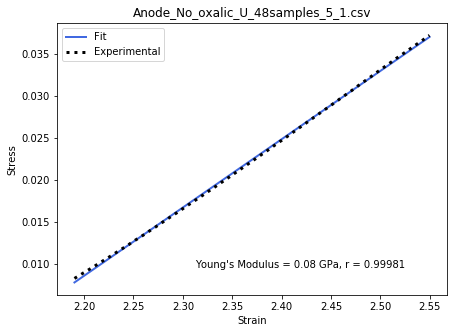

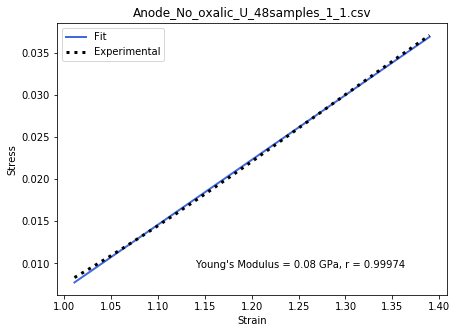

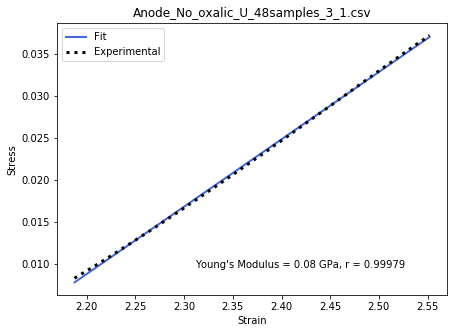

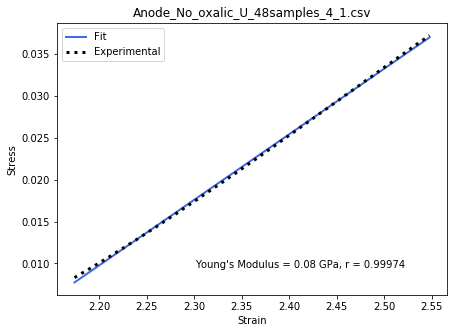

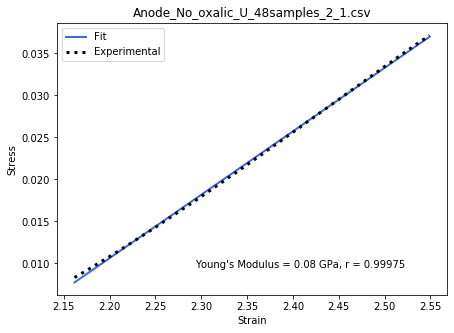

In [110]:
YM = np.zeros(numFiles)
r = np.zeros(numFiles)
for i in range(numFiles):
    '''import data files'''
    #print(fileNames[i])
    data = pd.read_csv(filepath +'/'+ fileNames[i])
    #print(len(data))
    raw_data = np.zeros((2,len(data)-1))
    for j in range(len(data)-1):
        raw_data[0][j] = float(data["Displacement"][j+1]) 
        raw_data[1][j] = float(data["Force"][j+1]) 
        
    '''remove excess data points where force is less than 0.005 kN'''
    o = 0
    for j in range(len(data)-1):
        if raw_data[1][j] > 0.005:
            o = np.append(o,j)
    
    e = (o[len(o)-1]-o[1])
    n_data = np.zeros((2,e))
    for j in range(e):
        n_data[0][j] = raw_data[0][j+o[1]]
        n_data[1][j] = raw_data[1][j+o[1]]
    
    '''remove excess data points where force is less than 1.0 kN'''
    u = 0
    for j in range(len(data)-1):
        if raw_data[1][j] > 1.0:
            u = np.append(u,j)
            
    f = (u[len(u)-1]-u[1])
    a_data = np.zeros((2,f))
    for j in range(f):
        a_data[0][j] = raw_data[0][j+u[1]]
        a_data[1][j] = raw_data[1][j+u[1]]
        
    '''find the point where maximum force is applied'''    
    s = 4.5
    for j in range(len(a_data[1])):
        if a_data[1][j] > s:
            s = j
    
    '''calculates strain and stress'''
    ss = np.zeros((2,f))
    for j in range(f):
        ss[0][j] = a_data[0][j]/stack_height #strain          
        ss[1][j] = a_data[1][j]/area #stress 
        
    '''put positive curve in it's own array'''
    p_ss = np.zeros((2,s))
    for j in range(s):
        p_ss[0][j] = ss[0][j]
        p_ss[1][j] = ss[1][j]
    
    '''calculates Young's Modulus'''
    z = linregress(p_ss)
    YM[i] = z[0]
    r[i] = z[2]
    #print(z)
    
    '''plots strain and stress'''
    plt.figure(figsize=(7, 5)) 
    plt.title(fileNames[i])
    '''plt.plot(n_data[0],n_data[1],linewidth=1)
    plt.xlabel('Displacement')
    plt.ylabel('Force (kN)')
    plt.legend(fileNames[i])'''
    plt.plot(p_ss[0],z[0]*p_ss[0]+z[1],'royalblue',linewidth=2,label='Fit') 
    plt.plot(p_ss[0],p_ss[1],'k.',linewidth=3,label='Experimental') 
    plt.xlabel('Strain')
    plt.ylabel('Stress')
    plt.figtext(0.4,0.2,"Young's Modulus = " + str(round(YM[i],2)) +" GPa, " + "r = " + str(round(r[i],5)))
    plt.legend()
    plt.savefig(graphPath + "_" + fileNames[i] + ".pdf", bbox_inches = "tight") #Saves the image of the model with the data

In [112]:
'''function that calculates the average Young's Modulus with 95% Confidence Interval from all files'''

def stat(k):
    k1,k2,k3,k4 = k
    tt = t.ppf(0.95,numFiles-1)
    σ = tstd(k)
    μ = tmean(k)
    cl = tt*σ/numFiles**0.5
    #print(μ(average), "+/-", cl)
    return [μ, cl]

In [113]:
'''saves results in an excel file'''

fileNames = np.append(fileNames,' ')
fileNames = np.append(fileNames,'Average YM')
fileNames = np.append(fileNames,'95% CI')
writer = pd.ExcelWriter(excelPath)

workbook = writer.book
df  = pd.DataFrame(fileNames)
df2 = pd.DataFrame(YM)
df3 = pd.DataFrame(r)
df4 = pd.DataFrame(stat(YM))

writer.sheets["Data"] = workbook.add_worksheet("Data") 
df.to_excel(writer, sheet_name = "Data", index = False, header = ["File"], startcol = 0)  #saves the file names 
df2.to_excel(writer, sheet_name = "Data", index = False, header = ["Young's Modulus"], startcol = 1)  
df3.to_excel(writer, sheet_name = "Data", index = False, header = ["R value"], startcol = 2)
df4.to_excel(writer, sheet_name = "Data", index = False, header = False, startrow = (numFiles+2), startcol = 1)

writer.save()